In [30]:
import pandas as pd
import numpy as np
import os
%matplotlib inline 

In [31]:
user = "kowalej"

D:\Documents\KEEGLogger\KEEGLogger\KEEGLogger\session_data\kowalej\PIN_FIXED_4\kowalej_PIN_FIXED_4_2018-07-06-02-44-25_2018-07-06-02-46-41


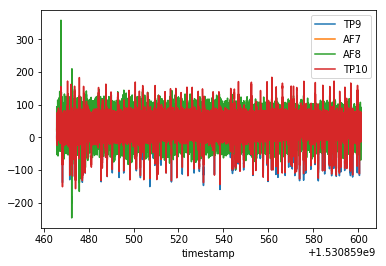

In [32]:
#cwd is based from root of KEEGLogger

dir_path = os.path.dirname(os.getcwd())
dataNameBase = os.path.join(dir_path,'session_data',user,'PIN_FIXED_4',user+'_PIN_FIXED_4_2018-07-06-02-44-25_2018-07-06-02-46-41')
print(dataNameBase)
dfEEG = pd.read_csv(dataNameBase + "_EEG.csv")
dfMRK = pd.read_csv(dataNameBase + "_MRK.csv")
dfEEG = dfEEG.drop(columns=['Right AUX'])
dfEEG.plot(x = 'timestamp')

In [33]:
SAMPLE_WINDOW_SIZE_BEFORE = 15
SAMPLE_WINDOW_SIZE_AFTER = 38
SAMPLE_WINDOW_SIZE = SAMPLE_WINDOW_SIZE_BEFORE + SAMPLE_WINDOW_SIZE_AFTER
SAMPLE_TIME_DELTA = 0.1 #difference between time stamps from eeg and marker to match a hit
SAMPLE_SHAPE = (len(dfMRK),SAMPLE_WINDOW_SIZE,2) # n samples with a window size of _ and which key was pressed
SAMPLE_FEATURES = ['TP9','AF7','AF8','TP10']

In [34]:
def createTrainingSamples(df_eeg:pd.DataFrame,df_mrk:pd.DataFrame):
    samples = []
    eeg_index = 0
    for mark in df_mrk.itertuples():
        sample_index = mark.Index
        key_press = mark._2
        mrk_timestamp = mark[1]
        while True:
            if eeg_index >= len(df_eeg.index) - SAMPLE_WINDOW_SIZE_AFTER - 1:
                break
            eeg_timestamp = df_eeg.iloc[eeg_index].timestamp
            delta = abs(eeg_timestamp-mrk_timestamp)
            if (delta < SAMPLE_TIME_DELTA):
                samples.append([df_eeg.iloc[eeg_index-SAMPLE_WINDOW_SIZE_BEFORE:eeg_index+SAMPLE_WINDOW_SIZE_AFTER][SAMPLE_FEATURES].as_matrix(),key_press])
                eeg_index += SAMPLE_WINDOW_SIZE_AFTER
                break
            eeg_index += 1
    return samples

In [35]:
import matplotlib.pyplot as plt

def viewDataForKeyPress(samples,keyPressed=0,instance=None):
    count = 0
    for sample in samples:
        if (sample[1] == keyPressed):
            count += 1
            if(instance is not None):
                if (count == instance):
                    plt.plot(sample[0])
            else:
                plt.plot(sample[0])
    print('There are %d samples for key = %d' % (count,keyPressed))
    if (instance is not None):
        plt.legend(SAMPLE_FEATURES)
    plt.show()

In [36]:
samples = createTrainingSamples(dfEEG,dfMRK)
#samples

d:\documents\keeglogger\keeglogger\env\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


There are 20 samples for key = 9


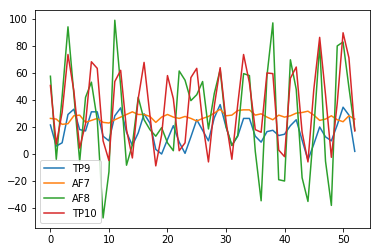

In [37]:
viewDataForKeyPress(samples,9,1)

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_shape=(4*7,), activation='relu'))
    model.add(Dense(10,activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [39]:
seed = 7
np.random.seed(seed)

In [86]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=15, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [ ]:
num_of_train_samples = 25

train, test = samples[:num_of_train_samples],samples[num_of_train_samples+1:]
raw_train_x = [series[0] for series in train]
train_y = [series[1] for series in train]

#modify data for a simple model
mod_features = ['mean','std','min','25%','50%','75%','max']
mod_train_x = []

for sample in raw_train_x:
    df = pd.DataFrame(sample)
    agg = df.describe()
    mod_train_x.append(agg.drop('count').values.flatten())

mod_train_x = np.array(mod_train_x)

one_hot_y = np.zeros((len(train_y), 10))
one_hot_y[np.arange(len(train_y)), train_y] = 1

results = cross_val_score(estimator, mod_train_x, one_hot_y, cv=kfold)

In [ ]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))